In [207]:
import warnings
warnings.filterwarnings('ignore')

In [208]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [209]:
x1 = np.linspace(0,20,num = 215)
x2 = np.linspace(40,255,num = 215)
x3 = np.linspace(80,255,num = 215)

In [210]:
data = {'hue':x1,'saturation':x2,'value':x3}
df = pd.DataFrame(data)
df

,hue,saturation,value
0,0.000000,40.000000,80.000000
1,0.093458,41.004673,80.817757
2,0.186916,42.009346,81.635514
3,0.280374,43.014019,82.453271
4,0.373832,44.018692,83.271028
...,...,...,...
210,19.626168,250.981308,251.728972
211,19.719626,251.985981,252.546729
212,19.813084,252.990654,253.364486
213,19.906542,253.995327,254.182243


In [211]:
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc

In [212]:
# sc = StandardScaler()
# df_scaled = sc.fit_transform(df)
# df_normalized = normalize(df_scaled)

In [213]:
# Reduce the dimensionality of data to 3 features
#
# pca = PCA(n_components=3)
# df_pca = pca.fit_transform(df_normalized)
# df_pca = pd.DataFrame(df_pca)
# df_pca.columns = ['P1', 'P2', 'P3']

In [214]:
# Create the Dendogram plot
#
# plt.figure(figsize =(8, 8))
# plt.title('Visualising the data')
# dendrogram = hc.dendrogram((hc.linkage(df, method ='ward')))

In [215]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [216]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  # Defining HSV Threadholds
  lower_threshold = np.array([0, 40, 80], dtype=np.uint8)
  upper_threshold = np.array([25, 255, 255], dtype=np.uint8)
  
  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)
  
  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  
  # Extracting skin from the threshold mask
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)
  
  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

  

In [217]:
def removeBlack(estimator_labels, estimator_cluster):
  
  
  # Check for black
  hasBlack = False
  
  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)

  
  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)
   
  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]
    
  
    
    # Check if the color is [0,0,0] that if it is black 
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster 
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break
      
  return (occurance_counter,estimator_cluster,hasBlack)

In [218]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):
  
  # Variable to keep count of the occurance of each color predicted
  occurance_counter = None
  
  # Output list variable to return
  colorInformation = []
  
  
  #Check for Black
  hasBlack =False
  
  # If a mask has be applied, remove th black
  if hasThresholding == True:
    
    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black
    
  else:
    occurance_counter = Counter(estimator_labels)
 
  # Get the total sum of all the predicted occurances
  totalOccurance = sum(occurance_counter.values()) 
  
 
  # Loop through all the predicted colors
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    index = (int(x[0]))
    
    # Quick fix for index out of bound when there is no threshold
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index
    
    # Get the color number into a list
    color = estimator_cluster[index].tolist()
    
    # Get the percentage of each color
    color_percentage= (x[1]/totalOccurance)
    
    #make the dictionay of the information
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }
    
    # Add the dictionary to the list
    colorInformation.append(colorInfo)
    
      
  return colorInformation 

In [219]:

def extractDominantColor(image,number_of_colors=2,hasThresholding=False):
  
  # Quick Fix Increase cluster counter to neglect the black 
  if hasThresholding == True:
    number_of_colors +=1
  
  # Taking Copy of the image
  img = image.copy()
  
  # Convert Image into RGB Colours Space
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)

#Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)
  
  # Fit the image
  estimator = estimator.fit(img)

  
  # Get Colour Information
  colorInformation_kmeans = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  #print("------------------------",colorInformation[estimator.cluster_centers_])
  check_center = estimator.cluster_centers_
  #print("++++++++++++++++++",check_center)
  return colorInformation_kmeans



  # using the agglomerative

  estimator_h = AgglomerativeClustering(n_clusters = number_of_colors)

  #Initiate KMeans Object
  # estimator_kmeans = KMeans(n_clusters=number_of_colors, random_state=0)
  # colorInformation_kmeans = getColorInformation(estimator_kmeans.labels_,estimator_kmeans.cluster_centers_,hasThresholding)
  # # Fit the image
  estimator_h.fit(img)
  print("+++++++++++++++++++++++++=",estimator_h)
  
  estimator_h.children_ = check_center

  # Get Colour Information
  colorInformation = getColorInformation(estimator_h.labels_,estimator_h.children_,hasThresholding)
  print("checking ===================",estimator_h.children_)
  
  #print("------------------------",colorInformation)
  return colorInformation
  
  

In [220]:
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,500,3), dtype="uint8")
  
  top_x = 0
  for x in colorInformation:    
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))
  
    cv2.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x
  return color_bar

In [221]:
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()

Check----------------------------2


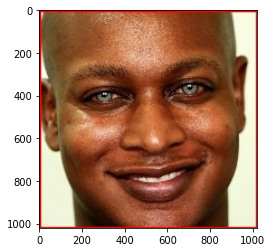

check-----------------------------3
check-----------------------------4


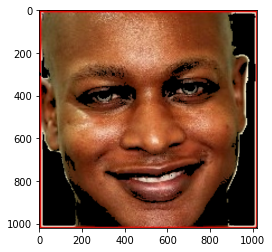

Check---------------------------------5
check-----------------------------6
Color Information
{'cluster_index': 0,
 'color': [131.59759115772167, 63.01219931618298, 32.56392839558957],
 'color_percentage': 0.5695290272971933}

{'cluster_index': 2,
 'color': [202.5409306647388, 133.4680948546174, 96.03257016012445],
 'color_percentage': 0.2166753171856978}

{'cluster_index': 1,
 'color': [1.3114342868450706, 0.3335071589958858, 0.08333745414966387],
 'color_percentage': 0.2137956555171088}

Color Bar


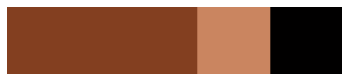

In [222]:
image = cv2.imread('/content/x.jpg')

# Resize image to a width of 250
image = imutils.resize(image,width=1020)

print("Check----------------------------2")

plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

print("check-----------------------------3")
skin = extractSkin(image)

print("check-----------------------------4")

plt.imshow(cv2.cvtColor(skin,cv2.COLOR_BGR2RGB))
plt.show()
print("Check---------------------------------5")


dominantColors = extractDominantColor(skin,hasThresholding=True)

print("check-----------------------------6")

#Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

#Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.axis("off")
plt.imshow(colour_bar)
plt.show()